## 1.1 Title & Abstract

## Title:
 **Causal-Ready Data Preparation for Propensity Scores: Missing Data, Encoding, and Bias from Conditioning**

### Abstract
Causal inference estimates the effect of an intervention (treatment) on an outcome, which is fundamentally different from predicting outcomes. In observational machine learning settings, treatment assignment is rarely randomized, so credible effect estimation depends on careful data preparation and explicit causal assumptions. This notebook focuses on propensity score based causal analysis and shows how preprocessing decisions directly affect causal validity. Using directed acyclic graphs (DAGs), we explain how to select an adjustment set by distinguishing confounders from mediators and colliders, and why conditioning on the wrong variables can introduce selection bias. We then cover practical preprocessing choices for causal workflows, including diagnosing missingness mechanisms, handling missing confounders without changing the target population, and encoding categorical covariates in a way that avoids outcome leakage. A minimal, reproducible code workflow demonstrates propensity score estimation, overlap checks, covariate balance diagnostics, and effect estimation with inverse probability weighting, along with a simple robustness check. These ideas apply to program evaluation, healthcare analytics, and marketing uplift, where decisions require interpretable treatment effects rather than high predictive accuracy.

---

## 1.2 Theory

### 1.2.1 Causal inference vs predictive modeling
Predictive modeling asks: *given features \(X\), how accurately can we predict outcome \(Y\)?* Causal inference asks: *how would \(Y\) change if we intervened to set treatment \(T\) to a different value?* This distinction matters because a feature that improves prediction may be inappropriate to condition on for causal estimation (for example, a collider or a post-treatment variable). In causal work, the objective is not a best-fitting model of \(Y\), but a valid estimate of an intervention’s effect under explicit assumptions.

A common causal estimand is the **Average Treatment Effect (ATE)**:

$$
\text{ATE} = \mathbb{E}\left[ Y(1) - Y(0) \right]
$$

where $Y(1)$ and $Y(0)$ are potential outcomes under treatment and control.

---

### 1.2.2 Propensity scores as a focused causal method
In observational data, treated and control groups often differ systematically. **Propensity scores** summarize the probability of treatment given observed covariates:
$$
e(X) = P(T=1 \mid X)
$$
If we can adjust for the right covariates \(X\), propensity score methods (matching, weighting, or stratification) aim to create comparability between treated and control groups, approximating a randomized experiment.

This notebook focuses on propensity-score-based estimation using **inverse probability weighting (IPW)** because it highlights a key message: *data preparation choices directly change the propensity model and therefore the causal estimate.*

---

### 1.2.3 Identifying assumptions
Propensity score methods typically depend on the following assumptions:

- **SUTVA (Stable Unit Treatment Value Assumption):** each unit’s outcome depends only on its own treatment (no interference), and treatment is well-defined.
- **Unconfoundedness / conditional exchangeability:**  
  $$
  Y(t) \perp T \mid X
  $$
  meaning that after adjusting for covariates \(X\), treatment assignment is “as-if random.”
- **Positivity / overlap:**  
  $$
  0 < P(T=1 \mid X) < 1
  $$
  for all covariate patterns of interest, so both treatment states are possible in the data.

If these assumptions are violated (especially due to unmeasured confounding), effect estimates can be biased even if the code executes perfectly. A credible notebook states these assumptions up front and evaluates diagnostics (overlap and balance) to assess plausibility.

---

### 1.2.4 DAGs: confounders, mediators, and colliders
Directed acyclic graphs (DAGs) provide a disciplined way to choose which variables to adjust for.

- **Confounder:** a common cause of \(T\) and \(Y\). Not adjusting for confounders creates bias by leaving open “backdoor” paths.
- **Mediator:** a variable on the causal path from \(T\) to \(Y\) (e.g., \($T \rightarrow M \rightarrow Y$\)). Adjusting for a mediator blocks part of the effect and changes the estimand (total vs direct effect).
- **Collider:** a common effect of two variables (e.g., \($T \rightarrow C \leftarrow U$\)). Conditioning on a collider opens a non-causal path and can introduce spurious associations (selection bias).

A key causal lesson for data preparation is: **“more features” is not automatically better.** Variable inclusion should follow the causal structure, not predictive convenience.

---

### 1.2.5 Data preparation in a causal framework
Propensity score methods depend on the covariates \(X\). If preprocessing distorts \(X\), it distorts \(e(X)\), which can harm overlap, balance, and the final effect estimate.

#### Missing data for causal inference
Missingness can change the target population and induce selection bias.

- **MCAR:** missingness independent of observed and unobserved values; dropping rows mainly reduces power.
- **MAR:** missingness depends on observed data; principled imputation can be reasonable if it uses appropriate predictors and avoids outcome leakage.
- **MNAR:** missingness depends on unobserved values; standard imputation may be biased, and sensitivity analysis is often needed.

Practical causal-safe strategies include:
- **Missingness indicators** for confounders (explicit “is_missing” flags),
- **Imputation using only pre-treatment information** (avoid using \(Y\) to fill \(X\)),
- **Reporting how results change** under alternative missing-data handling choices.

#### Feature selection for causal inference
Feature selection for prediction can be harmful for causality:
- A variable can be a weak predictor of \(Y\) but still a strong confounder (strongly related to \(T\)).
- A variable can be a strong predictor of \(Y\) but inappropriate to adjust for (collider or mediator).

Causal practice prioritizes **a justified adjustment set** (often from the DAG and domain knowledge) over automated selection based on predictive score.

#### Encoding categorical variables
Encoding affects both interpretability and bias risk:
- **One-hot encoding** is typically the safest default for categorical confounders.
- **Ordinal encoding** is appropriate only when a true order exists and should be respected.
- **Target encoding** can leak outcome information into features if not done carefully, which can bias causal estimates.

A reliable rule: preprocessing should not use information that makes covariates depend on the outcome in a way that differs across treatment groups.

---

### 1.2.6 Why these steps support causal interpretation
A coherent propensity score workflow ties theory to practice:
1. Define \(T\), \(Y\), and a defensible covariate set \(X\) (supported by a DAG).
2. Prepare \(X\) in ways consistent with causal assumptions (careful missingness handling, safe encoding, no leakage).
3. Estimate propensity scores \(e(X)\).
4. Diagnose **overlap** (positivity) and **balance** (comparability after adjustment).
5. Estimate effects (e.g., IPW ATE) and report robustness checks and limitations.

When preprocessing is aligned with causal structure, the estimated effect is more likely to represent a meaningful intervention and supports trustworthy decision-making in applied ML settings.


## 1.3 Practical Code Examples (Propensity Scores + IPW)

> This section provides a minimal, fully executable workflow that demonstrates:
> - How preprocessing decisions (missing data + encoding + “conditioning” mistakes) affect propensity scores and ATE estimates
> - How to check overlap (positivity) and covariate balance
> - How to estimate ATE using inverse probability weighting (IPW) and run a simple robustness check



### 1.3.1 Imports and reproducibility

In [14]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split  # Split data into train/test (or train/validation) to evaluate the propensity model without leakage.
from sklearn.compose import ColumnTransformer  # Apply different preprocessing to different column types (numeric vs categorical) in one pipeline.
from sklearn.pipeline import Pipeline  # Chain preprocessing + model steps into one reproducible, fit/transformable workflow.
from sklearn.preprocessing import OneHotEncoder  # Encode categorical variables into binary indicator columns for causal-safe modeling.
from sklearn.impute import SimpleImputer  # Handle missing values (median/most-frequent) and optionally add missingness indicators.
from sklearn.linear_model import LogisticRegression  # Estimate propensity scores by modeling P(T=1 | X) via a standard, interpretable classifier.


1.3.2 Generate a toy dataset with confounding + a collider + a mediator (and missingness)

#### Toy dataset (for demonstration)
We simulate data with known causal structure:
- `X` and `C` are pre-treatment confounders affecting treatment `T`.
- `M` is a mediator affected by `T`.
- `S` is a collider affected by both `T` and `Y`.
- Missingness is injected into `X` in a way that depends on `T` and `X` (not MCAR).
This lets us demonstrate how preprocessing choices (dropping missing rows, conditioning on colliders) can bias IPW estimates.


In [3]:
rng = np.random.default_rng(7390)
n = 4000

# Confounder (pre-treatment) affects both T and Y
X = rng.normal(0, 1, n)

# Categorical confounder (pre-treatment) that affects T (and indirectly Y through T)
C = rng.choice(["A", "B", "C"], size=n, p=[0.5, 0.3, 0.2])

# Treatment assignment depends on confounders -> confounding by design
logit_T = 0.9*X + (C == "B")*0.6 + (C == "C")*(-0.4)
p_T = 1 / (1 + np.exp(-logit_T))
T = rng.binomial(1, p_T)

# Mediator: affected by treatment
M = 0.8*T + 0.6*X + rng.normal(0, 1, n)

# Outcome: depends on treatment + confounder + mediator
true_tau = 1.5  # true causal effect of T on Y (part total effect flows through M too)
Y = true_tau*T + 0.9*X + 0.7*M + rng.normal(0, 1, n)

# Collider: affected by both treatment and outcome (conditioning on it can bias)
S = 0.8*T + 0.8*Y + rng.normal(0, 1, n)

df = pd.DataFrame({"T": T, "Y": Y, "X": X, "C": C, "M": M, "S": S})

# Introduce missingness in a confounder (MAR-like): missing depends on T and X
miss_prob = 1 / (1 + np.exp(-(0.7*T + 0.5*X - 0.2)))
mask = rng.binomial(1, miss_prob).astype(bool)
df.loc[mask, "X"] = np.nan

df.head()


,T,Y,X,C,M,S
0,0,-1.523368,0.820457,A,-0.705607,0.794436
1,0,0.553070,0.101073,C,-0.869448,-0.174980
2,0,3.585383,NaN,B,1.199170,3.148431
3,1,3.445099,0.587571,B,1.522504,3.122003
4,1,5.227350,NaN,C,2.649416,5.652648


#### 1.3.3 Define the causal question and variable roles
We explicitly define treatment, outcome, and variable roles to ensure the propensity model adjusts only for valid pre-treatment confounders and avoids mediators/colliders that can bias causal estimates.


In [4]:
# Treatment and outcome
treatment_col = "T"
outcome_col = "Y"

# Confounders (pre-treatment) to adjust for
confounders = ["X", "C"]

# Variables we should NOT adjust for when estimating total effect
mediators = ["M"]   # post-treatment
colliders = ["S"]   # conditioning can open spurious paths

print("Treatment:", treatment_col)
print("Outcome:", outcome_col)
print("Adjust (confounders):", confounders)
print("Do NOT adjust (mediators/colliders):", mediators + colliders)


Treatment: T
Outcome: Y
Adjust (confounders): ['X', 'C']
Do NOT adjust (mediators/colliders): ['M', 'S']


1.3.4 Helper functions: propensity scores, IPW ATE, balance (SMD), and plots

In [15]:
#Standardized mean difference 
def compute_smd(df_in, t_col, feature_cols, weights=None):
    """
    Standardized Mean Difference (SMD) for each feature.
    For categorical features, assumes they are already one-hot encoded in df_in.
    """
    t = df_in[t_col].values
    w = np.ones(len(df_in)) if weights is None else np.asarray(weights)

    smd = {}
    for col in feature_cols:
        x = df_in[col].values

        w1 = w[t == 1]
        w0 = w[t == 0]
        x1 = x[t == 1]
        x0 = x[t == 0]

        m1 = np.average(x1, weights=w1)
        m0 = np.average(x0, weights=w0)
        v1 = np.average((x1 - m1) ** 2, weights=w1)
        v0 = np.average((x0 - m0) ** 2, weights=w0)
        denom = np.sqrt(0.5 * (v1 + v0)) + 1e-12
        smd[col] = (m1 - m0) / denom

    return pd.Series(smd).sort_values(key=lambda s: np.abs(s), ascending=False)

#Inverse probability Weighting
def ipw_ate(df_in, t_col, y_col, e_hat, stabilize=False):
    """
    IPW estimate of ATE.
    If stabilize=True, use stabilized weights to reduce variance.
    """
    t = df_in[t_col].values
    y = df_in[y_col].values
    e = np.clip(e_hat, 1e-4, 1 - 1e-4)

    if stabilize:
        pt = t.mean()
        w = np.where(t == 1, pt / e, (1 - pt) / (1 - e))
    else:
        w = np.where(t == 1, 1 / e, 1 / (1 - e))

    mu1 = np.average(y[t == 1], weights=w[t == 1])
    mu0 = np.average(y[t == 0], weights=w[t == 0])
    ATE = mu1 - mu0
    return (mu1 - mu0), w


def plot_overlap(e_hat, t, title):
    plt.figure()
    plt.hist(e_hat[t == 1], bins=30, alpha=0.7, label="T=1")
    plt.hist(e_hat[t == 0], bins=30, alpha=0.7, label="T=0")
    plt.xlabel("Estimated propensity score e(X)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()


1.3.5 Baseline (biased) estimate: naive difference in means

In [6]:
naive = df.loc[df["T"] == 1, "Y"].mean() - df.loc[df["T"] == 0, "Y"].mean()
print("Naive difference in means (biased under confounding):", naive)


Naive difference in means (biased under confounding): 3.091272268812986


####  1.3.6 “Bad” preprocessing example (common mistake): condition on a collider + drop missing

This is intentionally incorrect to demonstrate how routine preprocessing can bias causal estimates.

BAD pipeline IPW ATE (expects bias): 0.9063565775432085


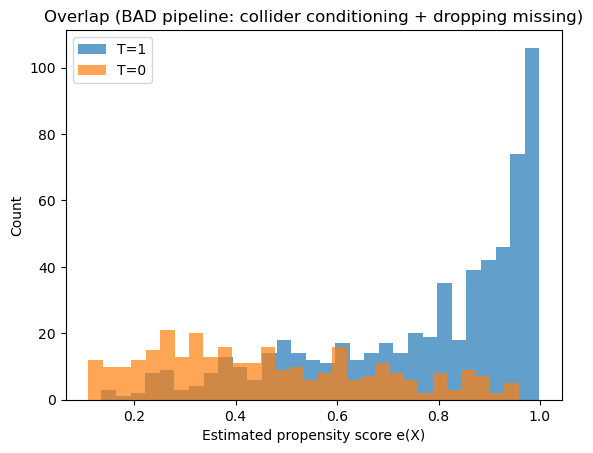

In [7]:
bad_df = df.dropna(subset=["X"]).copy()

# Conditioning on collider S (BAD) by filtering on a high value subset (selection bias)
bad_df = bad_df[bad_df["S"] > bad_df["S"].median()].copy()

# Fit propensity model on confounders + collider (BAD)
bad_features = ["X", "C", "S"]

bad_preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", ["X", "S"]),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["C"]),
    ],
    remainder="drop"
)

bad_model = Pipeline(steps=[
    ("prep", bad_preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

X_bad = bad_df[bad_features]
t_bad = bad_df["T"].values

bad_model.fit(X_bad, t_bad)
e_bad = bad_model.predict_proba(X_bad)[:, 1]

ate_bad, w_bad = ipw_ate(bad_df, "T", "Y", e_bad, stabilize=True)

print("BAD pipeline IPW ATE (expects bias):", ate_bad)
plot_overlap(e_bad, t_bad, "Overlap (BAD pipeline: collider conditioning + dropping missing)")


#### 1.3.7 Causal-aware preprocessing: adjust only for confounders, handle missingness, safe encoding

This is the intended workflow: adjust for pre-treatment confounders, avoid conditioning on colliders/mediators, and handle missing confounders transparently.

Causal-aware IPW ATE: 2.5708938395335226


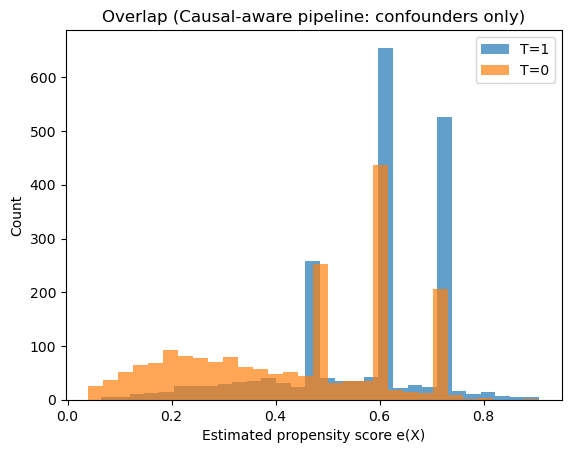

Weight summary (stabilized IPW):
count    4000.000000
mean        0.999194
std         0.480479
min         0.511275
50%         0.848585
90%         1.520262
95%         1.770485
99%         2.691801
max         8.013801
dtype: float64
Max weight: 8.013801271839029


In [23]:
good_df = df.copy()

good_features = confounders  # only ["X", "C"]

good_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median", add_indicator=True))
        ]), ["X"]),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), ["C"]),
    ],
    remainder="drop"
)

good_model = Pipeline(steps=[
    ("prep", good_preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

X_good = good_df[good_features]
t_good = good_df["T"].values

good_model.fit(X_good, t_good)
e_good = good_model.predict_proba(X_good)[:, 1]

ate_good, w_good = ipw_ate(good_df, "T", "Y", e_good, stabilize=True)

print("Causal-aware IPW ATE:", ate_good)
plot_overlap(e_good, t_good, "Overlap (Causal-aware pipeline: confounders only)")
# Weight diagnostics: check whether a few observations dominate the estimate
w = w_good
print("Weight summary (stabilized IPW):")
print(pd.Series(w).describe(percentiles=[0.5, 0.9, 0.95, 0.99]))
print("Max weight:", w.max())



1.3.8 Balance diagnostics (SMD before vs after weighting)

In [17]:
# Build a one-hot / numeric design matrix for balance reporting
Z = good_preprocess.fit_transform(good_df[good_features])

# Column names for transformed features
num_names = ["X"] + [f"X_missing_{i}" for i in range(Z.shape[1])]  # placeholder, will fix below
# Better: retrieve actual names from the transformer
ohe = good_preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_names = list(ohe.get_feature_names_out(["C"]))

# The numeric transformer produces 1 + indicators (if any)
# We can infer numeric output size:
num_out_dim = good_preprocess.named_transformers_["num"].fit(good_df[["X"]]).transform(good_df[["X"]]).shape[1]
num_names = ["X"] + [f"X_missing_ind_{k}" for k in range(1, num_out_dim)]

feature_names = num_names + cat_names

Z_df = pd.DataFrame(Z, columns=feature_names)
Z_df["T"] = good_df["T"].values

smd_before = compute_smd(Z_df, "T", feature_names, weights=None)
smd_after = compute_smd(Z_df, "T", feature_names, weights=w_good)

display(pd.DataFrame({
    "SMD_before": smd_before,
    "SMD_after_IPW": smd_after
}).head(12))


,SMD_before,SMD_after_IPW
C_A,-0.063623,0.012772
C_B,0.297183,-0.003040
C_C,-0.258409,-0.012290
X,0.470149,0.004696
X_missing_ind_1,0.485238,-0.000301


#### Covariate balance (SMD) results
Standardized mean differences (SMD) quantify covariate imbalance between treated and control groups. Before weighting, key confounders show substantial imbalance (e.g., `X` has SMD = 0.47 and the missingness indicator for `X` has SMD = 0.49), indicating strong confounding and non-random missingness patterns across treatment groups. After applying stabilized IPW, all reported SMDs shrink close to zero (e.g., `X`: 0.470 → 0.0047; `X_missing_ind_1`: 0.485 → −0.0003; `C_B`: 0.297 → −0.0030). This indicates that IPW successfully reweights the data to create comparability on observed pre-treatment covariates, supporting the credibility of the IPW ATE estimate (subject to the assumption of no unmeasured confounding).


#### 1.3.9 Simple robustness check: trim extreme propensity scores

If estimated propensities are too close to 0 or 1, weights explode and results become unstable. A common robustness check is trimming.

In [10]:
trim_low, trim_high = 0.05, 0.95
keep = (e_good >= trim_low) & (e_good <= trim_high)

trim_df = good_df.loc[keep].copy()
trim_e = e_good[keep]

ate_trim, w_trim = ipw_ate(trim_df, "T", "Y", trim_e, stabilize=True)

print("Trimmed IPW ATE:", ate_trim)
print("Kept fraction:", keep.mean())


Trimmed IPW ATE: 2.5640022103441975
Kept fraction: 0.99825


1.3.10 Interpretation (connect code to causal reasoning)

The naive difference in means is biased because treatment is confounded by pre-treatment covariates.

The “bad” pipeline demonstrates a common causal pitfall: conditioning on a collider (selection) and dropping missing confounders can distort group comparability and bias effect estimates.

The causal-aware pipeline restricts adjustment to pre-treatment confounders, handles missingness without changing the target population, checks overlap, and evaluates balance before trusting the IPW ATE.

## 1.4 Visualizations and Results

This section summarizes the key visuals used to validate propensity score assumptions and interpret causal estimates. The goal is to (1) make the causal assumptions explicit (DAG), (2) assess whether overlap/positivity is plausible, (3) verify covariate balance after weighting, and (4) report effect estimates with clear interpretation.

### 1.4.1 Causal diagram (DAG)
The diagram below represents the assumed causal structure used in this notebook. We adjust for the pre-treatment confounders (`X`, `C`) that affect both treatment `T` and outcome `Y`. We avoid conditioning on the mediator `M` (post-treatment) if the goal is the total effect, and we avoid conditioning on the collider `S` because it can introduce selection bias.


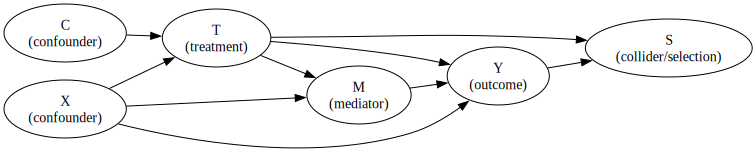

In [12]:
from graphviz import Digraph

dot = Digraph(graph_attr={"rankdir":"LR"})

dot.node("X", "X\n(confounder)")
dot.node("C", "C\n(confounder)")
dot.node("T", "T\n(treatment)")
dot.node("M", "M\n(mediator)")
dot.node("Y", "Y\n(outcome)")
dot.node("S", "S\n(collider/selection)")

dot.edges([("X","T"), ("C","T"), ("X","M"), ("T","M"), ("X","Y"), ("M","Y"), ("T","Y"), ("T","S"), ("Y","S")])
dot


Interpretation:

Adjust for X and C to block backdoor paths from T to Y.

Do not adjust for M when estimating the total effect.

Do not condition on S because it is a collider influenced by both T and Y.

### 1.4.2 Missingness visualization

Before modeling, we inspect missingness to understand whether dropping rows could change the target population.

,missing_rate
X,0.544
T,0.000
Y,0.000
C,0.000
M,0.000
S,0.000


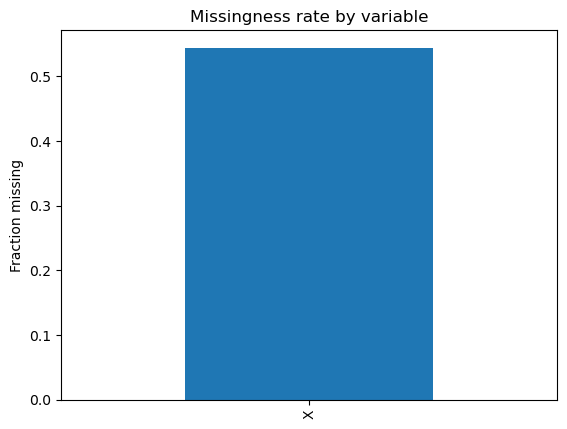

,P(X missing | T)
T,
0,0.424350
1,0.659303


In [13]:
# Missingness summary
missing_rate = df.isna().mean().sort_values(ascending=False)
display(pd.DataFrame({"missing_rate": missing_rate}))

# Missingness bar plot
plt.figure()
missing_rate[missing_rate > 0].plot(kind="bar")
plt.ylabel("Fraction missing")
plt.title("Missingness rate by variable")
plt.show()

# Check whether missingness in X relates to treatment (a red flag for selection bias if we drop rows)
df["X_missing"] = df["X"].isna().astype(int)
missing_by_t = df.groupby("T")["X_missing"].mean()
display(missing_by_t.to_frame("P(X missing | T)"))


### 1.4.3 Overlap (positivity) visualization
We assess the **positivity/overlap** assumption by comparing the distribution of estimated propensity scores \(e(X)=P(T=1\mid X,C)\) for treated and control groups. If the distributions barely overlap, IPW weights can become extreme and the ATE may be unstable.



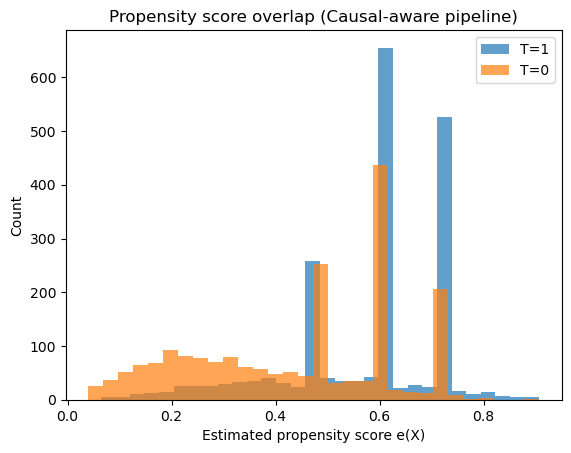

In [18]:

plot_overlap(e_good, t_good, "Propensity score overlap (Causal-aware pipeline)")


,SMD_before,SMD_after_IPW
C_A,-0.063623,0.012772
C_B,0.297183,-0.003040
C_C,-0.258409,-0.012290
X,0.470149,0.004696
X_missing_ind_1,0.485238,-0.000301


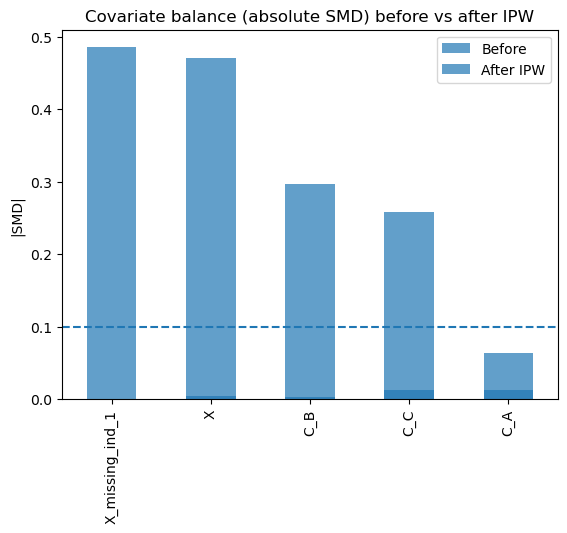

In [20]:
balance_table = pd.DataFrame({
    "SMD_before": smd_before,
    "SMD_after_IPW": smd_after
})

display(balance_table)

# Optional: visualize absolute SMD reduction (top features by pre-weight imbalance)
topk = 10
top_features = smd_before.abs().sort_values(ascending=False).head(topk).index

plt.figure()
balance_table.loc[top_features, "SMD_before"].abs().plot(kind="bar", alpha=0.7, label="Before")
balance_table.loc[top_features, "SMD_after_IPW"].abs().plot(kind="bar", alpha=0.7, label="After IPW")
plt.axhline(0.1, linestyle="--")
plt.ylabel("|SMD|")
plt.title("Covariate balance (absolute SMD) before vs after IPW")
plt.legend()
plt.show()


In [21]:
results = pd.DataFrame({
    "Estimator": [
        "Naive difference in means",
        "IPW ATE (BAD preprocessing)",
        "IPW ATE (Causal-aware preprocessing)",
        "IPW ATE (Trimmed propensities)"
    ],
    "Estimate": [
        naive,
        ate_bad,
        ate_good,
        ate_trim
    ]
})

display(results)


,Estimator,Estimate
0,Naive difference in means,3.091272
1,IPW ATE (BAD preprocessing),0.906357
2,IPW ATE (Causal-aware preprocessing),2.570894
3,IPW ATE (Trimmed propensities),2.564002


Interpretation (in causal terms):

The naive difference in means is biased under confounding because treatment assignment depends on pre-treatment covariates.

The “bad preprocessing” estimate is not credible because it conditions on a collider (S) and drops observations with missing confounder values (X), both of which can induce selection bias.

The causal-aware IPW estimate is supported by overlap and balance checks and therefore better aligns with the intended causal estimand under unconfoundedness.

Trimming is a robustness check for extreme weights. If trimmed and untrimmed estimates are similar, the result is less sensitive to limited overlap.

Results snapshot (from this notebook run):

Naive difference in means: 3.09

IPW ATE (BAD preprocessing): 0.91

IPW ATE (Causal-aware preprocessing): 2.57

Trimmed IPW ATE: 2.56 (kept 99.825% of observations)

These results illustrate how causal conclusions can change with preprocessing and why overlap and balance diagnostics are required before interpreting IPW estimates.



## 1.5 Conclusion

This notebook demonstrated a causal workflow centered on propensity scores and inverse probability weighting (IPW), emphasizing that preprocessing is part of causal identification, not just “data cleaning.” We made causal assumptions explicit using a DAG, selected an adjustment set consisting of pre-treatment confounders, and avoided conditioning on mediators and colliders that can bias estimates.

Key takeaways:
- Naive comparisons between treated and control groups can be substantially biased when treatment assignment depends on confounders.
- Propensity scores estimated from pre-treatment confounders can reweight the data to improve covariate balance, but the estimate is only credible after checking overlap (positivity) and balance (SMD).
- Missing data handling and feature inclusion decisions can change the target population and induce selection bias; causal-aware approaches (e.g., missingness indicators and safe encoding) help preserve interpretability.

In practical machine learning systems, causal-ready data preparation improves the reliability of treatment effect estimates used for decisions such as targeting interventions, evaluating programs, and designing policies, where predictive accuracy alone is insufficient.

---

## 1.6 References

1. Pearl, J. (2009). *Causality: Models, Reasoning, and Inference* (2nd ed.). Cambridge University Press.  
2. Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.  
3. Rosenbaum, P. R., & Rubin, D. B. (1983). The central role of the propensity score in observational studies for causal effects. *Biometrika, 70*(1), 41–55.  
4. Imbens, G. W., & Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*. Cambridge University Press.  
5. Austin, P. C. (2011). An introduction to propensity score methods for reducing the effects of confounding in observational studies. *Multivariate Behavioral Research, 46*(3), 399–424.

---

## 1.7 License

This project is released under the **MIT License**. See the `LICENSE` file in the repository for reuse permissions.
